In [1]:
%%writefile jb_geometry.py

import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

def rotateZ( theta ):
    rz = np.array( [ [ math.cos( theta ), - math.sin( theta ), 0, 0 ],
                           [ math.sin( theta ), math.cos( theta ), 0, 0 ],
                           [ 0, 0, 1, 0 ],
                           [ 0, 0, 0, 1 ] ] )
    return rz

def rotateY( theta ):
    ry = np.array( [ [ math.cos( theta ), 0, math.sin( theta ), 0 ],
                           [ 0, 1, 0, 0 ],
                           [ - math.sin( theta ), 0, math.cos( theta ), 0 ],
                           [ 0, 0, 0, 1 ] ] )
    return ry

def rotateX( theta ):
    rx = np.array( [ [ 1, 0, 0, 0 ],
                           [ 0, math.cos( theta ), - math.sin( theta ), 0 ],
                           [ 0, math.sin( theta ), math.cos( theta ), 0 ],
                           [ 0, 0, 0, 1 ] ] )
    return rx

def translate( dx, dy, dz ):
    t = np.array( [ [ 1, 0, 0, dx ],
                          [ 0, 1, 0, dy ],
                          [ 0, 0, 1, dz ],
                          [ 0, 0, 0, 1 ] ] )
    return t

def DHH( theta, d, a, alpha ):
    return rotateZ( theta ).dot( translate( 0, 0, d) ).dot( translate( a, 0, 0 ) ).dot( rotateX( alpha ) )

def plotCoordinateSystem( ax, length = 1.0, width = 1.0, A = None ):
    if ( A is None ):
        A = np.eye( 4 )
    xAxis = np.array( [ [ 0, 0, 0, 1], [ length, 0, 0, 1 ] ] ).T
    yAxis = np.array( [ [ 0, 0, 0, 1], [ 0, length, 0, 1 ] ] ).T
    zAxis = np.array( [ [ 0, 0, 0, 1], [ 0, 0, length, 1 ] ] ).T
    
    ax.plot( A.dot( xAxis )[0,:], A.dot( xAxis )[1,:], A.dot( xAxis )[2,:], 'r-', linewidth=width )
    ax.plot( A.dot( yAxis )[0,:], A.dot( yAxis )[1,:], A.dot( yAxis )[2,:], 'g-', linewidth=width )
    ax.plot( A.dot( zAxis )[0,:], A.dot( zAxis )[1,:], A.dot( zAxis )[2,:], 'b-', linewidth=width )

def drawLink(ax, A1, A2, width=1 ):
    x1 = A1.dot( np.array( [ 0, 0, 0, 1 ] ).T )
    x2 = A2.dot( np.array( [ 0, 0, 0, 1 ] ).T )
    c = np.vstack( (x1, x2 ) ).T
    print('x1', x1, 'x2', x2, 'c', c)
    ax.plot( c[0,:], c[1,:], c[2,:], color='#50303030', linewidth=width )


Writing jb_geometry.py


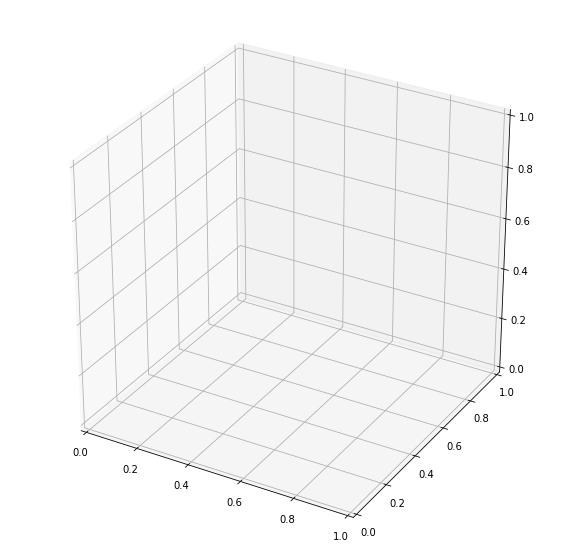

In [2]:
import math


import jb_geometry as jbg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_zlim((0,1))

LEFT_SHOULDER_LATERAL, LEFT_SHOULDER_FRONTAL, LEFT_ELBOW_LATERAL,  LEFT_ELBOW_FRONTAL, LEFT_GRIP_LATERAL = range(5)

def thormang_forward_kinematics_left( thetas ):

    # Draw the world coordinate system
    jbg.plotCoordinateSystem( ax, 0.5, 3.0 )

    # Draw the left shoulder Joint 1 (Lateral)
    leftShoulderTranslation = jbg.translate( 0.0, 0.225, 0.40 )
    leftShoulderRotation = jbg.rotateX( -90.0/180.0 * math.pi )
    j1AL = leftShoulderTranslation.dot( leftShoulderRotation )

    jbg.plotCoordinateSystem( ax, 0.25, 2.0, j1AL )

    j2_d = 0.1 # m
    j2_a = 0.05 # m
    j2TL = jbg.DHH( ( 90.0/180.0*math.pi + thetas[LEFT_SHOULDER_LATERAL] ), j2_d, j2_a, 90.0/180.0 * math.pi )

    j2AL = j1AL.dot(j2TL)
    jbg.plotCoordinateSystem( ax, 0.25, 2.0, j2AL )

    #jbg.drawLink(ax, j1A, j2A, width=25 )

    j3_d = 0.2
    j3_a = 0.05

    # Converted into one rotation around Z and one translation along X
    j3_dp = 0.0
    j3_ap = math.hypot( j3_d, j3_a)
    j3_theta = 90.0/180.0 * math.pi - math.atan2( j3_a, j3_d )
    j3TL= jbg.DHH( (j3_theta + thetas[LEFT_SHOULDER_FRONTAL]), j3_dp, j3_ap, 0.0/180.0 * math.pi )

    j3AL = j2AL.dot(j3TL)
    jbg.plotCoordinateSystem( ax, 0.25, 2.0, j3AL )

    # Joint 4
    j4_d = 0.22
    j4_a = -0.05

    # Convert into one translation along the X axis
    j4_dp = 0.0
    j4_ap = math.hypot( j4_d, j4_a)
    j4_theta = math.atan2( j3_a, j3_d ) + math.atan2( -j4_a, j4_d )

    #Breaking Denavit Hartenberg Convention
    j4TdL = jbg.DHH( j4_theta, j4_dp, j4_ap, 0.0/180.0 * math.pi )
    j4TL = jbg.DHH( j4_theta + thetas[LEFT_ELBOW_LATERAL], j4_dp, j4_ap, 0.0/180.0 * math.pi ).dot(jbg.rotateY(90.0/180.0*math.pi)).dot(jbg.rotateX( math.atan2( -j4_a, j4_d ) ) )

    j4AL = j3AL.dot(j4TL)
    j4AdL = j3AL.dot( j4TdL )

    jbg.plotCoordinateSystem( ax, 0.15, 2.0, j4AL )
    #jbg.plotCoordinateSystem( ax, 0.15, 2.0, j4Ad )

    j5_d = 0.07
    j5_a = 0

    j5TL = jbg.DHH( 90/180.0*math.pi + thetas[LEFT_ELBOW_FRONTAL], j5_d, 0, -90.0/180.0*math.pi )
    j5AL = j4AL.dot( j5TL )

    jbg.plotCoordinateSystem( ax, 0.15, 3.0, j5AL )

    j6_d = 0.1

    j6TL = jbg.DHH( -90/180.0*math.pi + thetas[LEFT_GRIP_LATERAL], 0, j6_d, 0 )
    j6AL = j5AL.dot( j6TL )

    jbg.plotCoordinateSystem( ax, 0.15, 5.0, j6AL )


    return j6AL





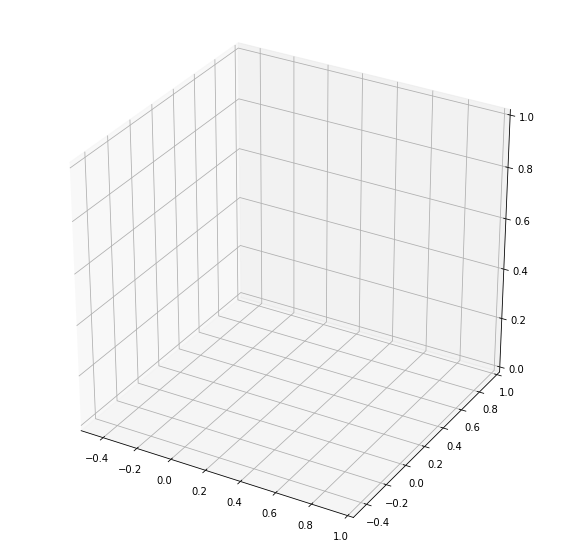

In [3]:



import jb_geometry as jbg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-0.5,1))
ax.set_ylim((-0.5,1))
ax.set_zlim((0,1))

RIGHT_SHOULDER_LATERAL, RIGHT_SHOULDER_FRONTAL, RIGHT_ELBOW_LATERAL, RIGHT_ELBOW_FRONTAL, RIGHT_GRIP_LATERAL = range(5)


# Joint 2
j2_d = 0.1 # m
j2_a = 0.05 # m

# Joint 3
# Measured in the image
j3_d = 0.2
j3_a = 0.05

# Converted into one rotation around Z and one translation along X
j3_dp = 0.0
j3_ap = math.hypot( j3_d, j3_a)
j3_theta = 90.0/180.0 * math.pi - math.atan2( j3_a, j3_d )

# Converted into one rotation around Z and one translation along X
j3_dp = 0.0
j3_apR = math.hypot( -j3_d, j3_a)
j3_thetaR = 90.0/180.0 * math.pi - math.atan2( j3_a, -j3_d )

# Joint 4
j4_d = 0.22
j4_a = -0.05

# Convert into one translation along the X axis
j4_dp = 0.0
j4_ap = math.hypot( j4_d, j4_a)
j4_theta = math.atan2( j3_a, j3_d ) + math.atan2( -j4_a, j4_d )


# Convert into one translation along the X axis
j4_dp = 0.0
j4_apR = math.hypot( j4_d, j4_a)
j4_thetaR = math.atan2( j3_a, -j3_d ) + math.atan2( -j4_a, -j4_d )

# Joint 5
j5_d = 0.07
j5_a = 0

# Gripper
j6_d = 0.1


def thormang_forward_kinematics_right( thetas ):

    # Draw the world coordinate system
    jbg.plotCoordinateSystem( ax, 0.5, 3.0 )

    # Draw the right shoulder Joint 1 (Lateral)
    rightShoulderTranslation = jbg.translate( 0.0, -0.225, 0.40 )
    rightShoulderRotation = jbg.rotateX( 90/180.0 * math.pi )
    j1AR = rightShoulderTranslation.dot( rightShoulderRotation )


    jbg.plotCoordinateSystem( ax, 0.25, 2.0, j1AR )

    j2TR = jbg.DHH( -90.0/180.0*math.pi + thetas[RIGHT_SHOULDER_LATERAL], -j2_d, -j2_a, -90.0/180.0 * math.pi )

    j2AR = j1AR.dot(j2TR)
    jbg.plotCoordinateSystem( ax, 0.25, 2.0, j2AR )


    #fig3 = addJBFigure( "fig3", 0, 0, fig )
    #jbg.drawLink(ax, j1AR, j2AR, width=25 )

    j3TR = jbg.DHH( j3_thetaR + thetas[RIGHT_SHOULDER_FRONTAL], j3_dp, j3_apR, 0.0/180.0 * math.pi )

    j3AR = j2AR.dot(j3TR)
    jbg.plotCoordinateSystem( ax, 0.25, 2.0, j3AR )


    #Breaking Denavit Hartenberg Convention
    j4TdR = jbg.DHH( j4_thetaR, j4_dp, j4_apR, 0.0/180.0 * math.pi )
    j4TR = jbg.DHH( j4_thetaR + thetas[RIGHT_ELBOW_LATERAL], j4_dp, j4_apR, 0.0/180.0 * math.pi ).dot(jbg.rotateY(-90.0/180.0*math.pi)).dot(jbg.rotateX( math.atan2( j4_a, -j4_d ) ) )

    j4AR = j3AR.dot(j4TR)
    j4AdR = j3AR.dot( j4TdR )

    #jbg.plotCoordinateSystem( ax, 0.15, 2.0, j4AR )


    j5TR = jbg.DHH( 90/180.0*math.pi + thetas[RIGHT_ELBOW_FRONTAL], -j5_d, 0, 90.0/180.0*math.pi )
    j5AR = j4AR.dot( j5TR )

    jbg.plotCoordinateSystem( ax, 0.15, 2.0, j5AR )


    j6TR = jbg.DHH( 90/180.0*math.pi + thetas[RIGHT_GRIP_LATERAL], 0, -j6_d, 0 )
    j6AR = j5AR.dot( j6TR )

    jbg.plotCoordinateSystem( ax, 0.15, 5.0, j6AR )

    return j6AR




In [4]:

#Step 1 
#Find angle between the dorso and arm 

l1 = 0.25 # m
l2 = 0.464 # m
dorso_center = 0.152 # m 
dist_robot = 0.51 # m
scotter_dic = 0.1 # m
scotter_mid = 0.3 # 
dorso_dic = scotter_mid - dorso_center - 0.04 # 102 mm



def angle_dorso_arm(dorso_dic, l1, l2):

    l = l1 + l2

    theta = math.asin(dorso_dic/l)
    
    return theta


def  angle_move_goal(tx, ty, l1, l2):

        # 1. Calculate l3
    l3 = math.sqrt( tx**2 + ty**2 )

    # 2. Calculate α_2 knee angle
    a2 = math.acos( (l1**2 + l2**2 - l3**2)/(2*l1*l2) )


    # 3. Calculate theta_2
    theta2d = math.pi - a2

    # 4. Calculate α_1
    # Sine law: math.sin(a2)/l3 = math.sin(a1)/l2

    a1 = math.asin( math.sin(a2)* l2/l3 )
    alpha = math.atan2( ty, tx )

    # Calculate theta1 from a2 and beta
    theta1 = alpha - a1
    
    return a2, theta1


def gripper(angle_th, angle_st):


    gripperangle = angle_th * 18 # considering that the gripper just moves between 0 and 180 


    d_th = abs(math.sin(gripperangle))

    dR =  angle_st * 0.001 + d_th * 0.01

    dL = - angle_st * 0.001 + d_th * 0.01
    


    return dL, dR, gripperangle



def calculate_IK(angle_st, angle_th, l1, l2, dorso_dic, dist_robot):

    angles_right = []

    angles_left = [] 

    #angles_right.append(angle_st)

    #angles_left.append(angle_st)

    #angles_right.append(angle_th)

    #angles_left.append(angle_th)

    dL, dR, gripper_angle = gripper(angle_th, angle_st)


    Dist = [dL, dR]

    theta1R = angle_dorso_arm(dorso_dic, l1, l2)

    theta1L = theta1R # shoulder 



    dist_robotL = dist_robot + dL
    

    dist_robotR = dist_robot + dR 

    alphaR, theta2R = angle_move_goal(dorso_dic, dist_robotR,l1, l2)

    alphaL, theta2L = angle_move_goal(dorso_dic, dist_robotL, l1, l2)


    # append the angles 

    # shoulder Lateral

    angles_right.append(theta1R/math.pi * 180.0)

    angles_left.append(theta1L/math.pi * 180.0)

    #should frontal

    angles_right.append(theta2R/math.pi * 180.0)

    angles_left.append(theta2L/math.pi * 180.0)

    # elbow

    angles_right.append(alphaR/math.pi * 180.0)

    angles_left.append(alphaL/math.pi * 180.0)

    # gripper

    angles_right.append(gripper_angle)

    angles_left.append(gripper_angle)

    return angles_right, angles_left





In [5]:
def steering(theta):
  targetR = [0,0.3,0,1]
  targetL = [0,-0.3,0,1]
  targetR = jbg.rotateZ(theta).dot(targetR)
  targetL = jbg.rotateZ(theta).dot(targetL)
  targetR = jbg.translate(0.51,0,0).dot(targetR)
  targetL = jbg.translate(0.51,0,0).dot(targetL)
  return (targetR,targetL)

In [6]:
angles_st = -15
angles_th = 1

#angles_st = 2
#angles_th = 2
angles_resultR = []
angles_resultL = []
check = []
i_element = -1 


for i in range(-20,21,5):
  angles_resultR.append([]) 
  angles_resultL.append([])
  check.append([])
  i_element += 1
  j_element = -1
  for j in range(0,11,2):        
    xR, xL = calculate_IK(i, j, l1, l2, dorso_dic, dist_robot)
    angles_resultR[i_element].append(xR)
    angles_resultL[i_element].append(xL)
    check[i_element].append((i,j))
    
def find_pose(check):
  for i in range(len(check)): 
    for j in range(len(check[0])):
      if check[i][j][0] > angles_st:
        if check[i][j][1] > angles_th:
          return i,j

new_ste,new_th = find_pose(check)

targetR, targetL = steering(angles_st/180*math.pi)

[0.9106574  1.75980954 0.98487365 0.80289348 2.43315137]


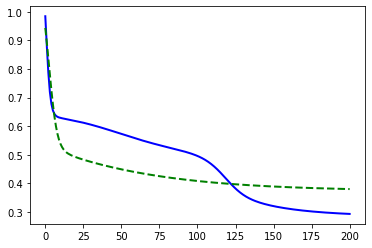

In [7]:
import numpy as np


sl,sf,el,gripper = angles_resultR[new_ste][new_th]
current_angles_R = [sl/180.0*math.pi,sf/180.0*math.pi,el/180.0*math.pi,45.0/180.0*math.pi,gripper/180.0*math.pi]
sl,sf,el,gripper = angles_resultL[new_ste][new_th]
current_angles_L = [sl/180.0*math.pi,sf/180.0*math.pi,el/180.0*math.pi,45.0/180.0*math.pi,gripper/180.0*math.pi]
current_position_R = thormang_forward_kinematics_right( current_angles_R ).dot([0,0,0.1,1])
current_position_L = thormang_forward_kinematics_left( current_angles_L ).dot([0,0,0.1,1])



def fwd_kinematicsR( thetas_R ):
  e2 = thormang_forward_kinematics_right(thetas_R).dot([0.0, 0.0, 0.1, 1] )
  return e2
def fwd_kinematicsL( thetas_L ):
  e1 = thormang_forward_kinematics_left(thetas_L).dot([0.0, 0.0, 0.1, 1] )
  return e1

def Jacobian( thetas, fkin ):
  J = np.zeros( (3, len(thetas) ) )
  current_pos = fkin( thetas )
  dt = 1.0/180.0*math.pi
  
  for i,t in enumerate(thetas):
    thetas_d = thetas.copy()
    thetas_d[i] = thetas_d[i] + dt
    p = fkin( thetas_d )
    J[0:3,i] = ( p[0:3] - current_pos[0:3] ) / dt
  return J

d_err_R = (targetR - current_position_R)[0:3]
d_err_L = (targetL - current_position_L)[0:3]

alpha = 0.5

count = 0
errs_L = []
errs_R = []


while( np.linalg.norm(d_err_R) + np.linalg.norm(d_err_L) > 0.4 ):

  current_position_R = thormang_forward_kinematics_right( current_angles_R ).dot([0,0,0.1,1])
  current_position_L = thormang_forward_kinematics_left( current_angles_L ).dot([0,0,0.1,1])
  
  
  d_err_R = (targetR - current_position_R)[0:3]
  d_err_L = (targetL - current_position_L)[0:3]

  errs_R.append( np.linalg.norm(d_err_R) )
  errs_L.append( np.linalg.norm(d_err_L) )


  jacR = Jacobian(current_angles_R, fwd_kinematicsR)
  jacL = Jacobian(current_angles_L, fwd_kinematicsL)


  d_theta_R = jacR.T.dot(d_err_R) 
  d_theta_L = jacL.T.dot(d_err_L) 


  current_angles_R = current_angles_R + alpha * d_theta_R
  current_angles_L = current_angles_L + alpha * d_theta_L

  
  count = count + 1
  if (count > 200 ):
    break

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(errs_L, "b-", errs_R, "g--", linewidth=2)

print(current_angles_R)


In [8]:

print(current_angles_R)

[0.9106574  1.75980954 0.98487365 0.80289348 2.43315137]


In [10]:
jacL

array([[-0.26048774, -0.3631089 , -0.26359036,  0.08279404, -0.09488528],
       [ 0.        , -0.41770933, -0.24492278,  0.0634043 , -0.02584096],
       [-0.28152483,  0.19098166,  0.13863864,  0.00284344, -0.01813216]])

In [11]:
targetR

array([0.58764571, 0.28977775, 0.        , 1.        ])